<a href="https://colab.research.google.com/github/shintafiaa/Tel-U-ML-Course/blob/main/WEEK%209%20Multi%20Layer%20Perceptron%20and%20NN/4.10.%20Predicting_House_Prices_on_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
pip install torch torchvision

In [123]:
pip install -U d2l

  Using cached pandas-1.2.2-cp37-cp37m-manylinux1_x86_64.whl (9.9 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.2.2 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.


Now that we have introduced some basic tools for building and training deep networks and regularizing with techniques including weight decay and dropout.

In this section, we will walk you through details of data preprocessing, model design, and hyperparameter selection.

##4.10.1. Downloading and Caching Datasets


In [124]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

download function

In [125]:
def download(name, cache_dir=os.path.join('..', 'data')): 
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

We also implement two additional utility functions: one is to download and extract a zip or tar file and the other to download all the datasets used in this book from DATA_HUB into the cache directory.

In [126]:
def download_extract(name, folder=None): 
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

##4.10.2. Kaggle
URL: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

##4.10.3. Accessing and Reading the Dataset
Each record includes the property value of the house and attributes such as street type, year of construction, roof type, basement condition, etc. The features consist of various data types.

To get started, we will read in and process the data using pandas.

In [127]:
#Accessing and Reading the Dataset
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

Download and cache the Kaggle housing dataset using the script we defined above

In [128]:
DATA_HUB['kaggle_house_train'] = ( 
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = ( 
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

We use pandas to load the two csv files containing training and test data respectively.

In [129]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

The training dataset includes 1460 examples, 80 features, and 1 label, while the test data contains 1459 examples and 80 features.

In [130]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


Let us take a look at the first four and last two features as well as the label (SalePrice) from the first four examples.

In [131]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


We can see that in each example, the first feature is the ID. This helps the model identify each training example. While this is convenient, it does not carry any information for prediction purposes. Hence, we remove it from the dataset before feeding the data into the model.

In [132]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

##4.10.4. Data Preprocessing
As stated above, we have a wide variety of data types. We will need to preprocess the data before we can start modeling. Let us start with the numerical features. First, we apply a heuristic, replacing all missing values by the corresponding feature’s mean. Then, to put all features on a common scale, we standardize the data.

Intuitively, we standardize the data for two reasons. First, it proves convenient for optimization. Second, because we do not know a priori which features will be relevant, we do not want to penalize coefficients assigned to one feature more than on any other.

In [133]:
# If test data were inaccessible, mean and standard deviation could be
# calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

Next we deal with discrete values.This includes features such as “MSZoning”. We replace them by a one-hot encoding in the same way that we previously transformed multiclass labels into vectors (see Section 3.4.1). For instance, “MSZoning” assumes the values “RL” and “RM”. Dropping the “MSZoning” feature, two new indicator features “MSZoning_RL” and “MSZoning_RM” are created with values being either 0 or 1. According to one-hot encoding, if the original value of “MSZoning” is “RL”, then “MSZoning_RL” is 1 and “MSZoning_RM” is 0. The pandas package does this automatically for us.

In [134]:
# `Dummy_na=True` considers "na" (missing value) as a valid feature value, and
# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

this conversion increases the number of features from 79 to 331. Finally, via the values attribute, we can extract the NumPy format from the pandas format and convert it into the tensor representation for training.

In [135]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

##4.10.5. Training
To get started we train a linear model with squared loss. 

In [136]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

root-mean-squared-error between the logarithm of the predicted price and the logarithm of the label price:

In [137]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

Optimizing

In [138]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

##4.10.6.  K -Fold Cross-Validation
Note that this is not the most efficient way of handling data and we would definitely do something much smarter if our dataset was considerably larger. But this added complexity might obfuscate our code unnecessarily so we can safely omit it here owing to the simplicity of our problem.

In [139]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

The training and verification error averages are returned when we train  K  times in the  K -fold cross-validation.

In [140]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

##4.10.7. Model Selection
In this example, we pick an untuned set of hyperparameters. Finding a good choice can take time, depending on how many variables one optimizes over.

fold 1, train log rmse 0.170118, valid log rmse 0.156855
fold 2, train log rmse 0.162351, valid log rmse 0.190297
fold 3, train log rmse 0.163850, valid log rmse 0.168500
fold 4, train log rmse 0.168149, valid log rmse 0.154545
fold 5, train log rmse 0.163267, valid log rmse 0.183048
5-fold validation: avg train log rmse: 0.165547, avg valid log rmse: 0.170649


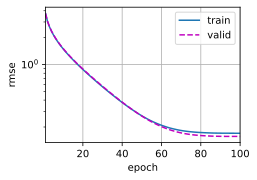

In [141]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

Notice that sometimes the number of training errors for a set of hyperparameters can be very low, even as the number of errors on  K -fold cross-validation is considerably higher. This indicates that we are overfitting. Throughout training you will want to monitor both numbers. Less overfitting might indicate that our data can support a more powerful model. Massive overfitting might suggest that we can gain by incorporating regularization techniques.

Now that we know what a good choice of hyperparameters should be, we might as well use all the data to train on it.

In [142]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

One nice sanity check is to see whether the predictions on the test set resemble those of the  K -fold cross-validation process.

In [145]:
!pip uninstall pandas
!pip install pandas --upgrade

Found existing installation: pandas 1.2.2
Uninstalling pandas-1.2.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/pandas-1.2.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pandas/*
Proceed (y/n)? y
  Successfully uninstalled pandas-1.2.2
  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
d2l 0.17.3 requires pandas==1.2.2, but you have pandas 1.3.5 which is incompatible.


In [147]:
pip install pandas==1.1.5

     |████████████████████████████████| 9.5 MB 24.5 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.25.1 which is incompatible.
d2l 0.17.3 requires pandas==1.2.2, but you have pandas 1.1.5 which is incompatible.


train log rmse 0.162459


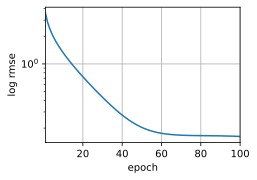

In [148]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

## Summary
* Real data often contain a mix of different data types and need to be preprocessed.

* Rescaling real-valued data to zero mean and unit variance is a good default. So is replacing missing values with their mean.

* Transforming categorical features into indicator features allows us to treat them like one-hot vectors.

* We can use  K -fold cross-validation to select the model and adjust the hyperparameters.

* Logarithms are useful for relative errors.